# MODULES

In [1]:
!pip install pathlib
!pip install matplotlib

In [2]:
!nvidia-smi

Tue Aug 26 12:24:13 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.230.02             Driver Version: 535.230.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060        Off | 00000000:01:00.0  On |                  N/A |
| 52%   66C    P2             128W / 170W |   7435MiB / 12288MiB |     98%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

1.13.1+cu117
11.7
NVIDIA GeForce RTX 3060


In [4]:
import cv2
import os
import math
import time
import random
import pathlib
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

WARNING ⚠️ Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View Ultralytics Settings with 'yolo settings' or at '/home/zionsflow/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# GLOBAL VARIABLES

In [5]:
ROOT_DIR_IMAGES = '../Kaggle'

# VIDEOS

In [6]:
def get_videos(root_dir):
  paths = []
  for path in pathlib.Path(root_dir).glob('*.mp4'):
    paths.append(path)

  paths = sorted(paths)

  return paths



def save_images(images, refPath, prefix="crop"):
    os.makedirs(refPath, exist_ok=True)  # create folder if it doesn't exist

    for i, img in enumerate(images):
        # Build filename: e.g., crop_0.png, crop_1.png, ...
        filename = os.path.join(refPath, f"{prefix}_{i}.jpeg")

        # OpenCV expects uint8 images; convert if needed
        if img.dtype != 'uint8':
            img_to_save = (img * 255).astype('uint8') if img.max() <= 1 else img.astype('uint8')
        else:
            img_to_save = img

        # Save image
        cv2.imwrite(filename, img_to_save)

    print(f"Saved {len(images)} images to {refPath}")
        

In [7]:
videos = {}
videos['fall']     = get_videos( ROOT_DIR_IMAGES + '/Fall/Raw_Video')
videos['no_fall'] = get_videos( ROOT_DIR_IMAGES + '/No_Fall/Raw_Video')

print(f"[INFO] videos dict keys: {list(videos.keys())}")
print(f"[INFO] videos['fall'] has {len(videos['fall'])} entries")
print(f"[INFO] videos['no_fall'] has {len(videos['no_fall'])} entries")

[INFO] videos dict keys: ['fall', 'no_fall']
[INFO] videos['fall'] has 3140 entries
[INFO] videos['no_fall'] has 3848 entries


In [8]:
def get_person_crops(video_path, model_path="yolov8l.pt", conf_thres=0.5):
    """
    Reads a video, applies YOLO person detection, and returns cropped person images.

    Args:
        video_path (str): Path to the .mp4 video
        model_path (str): Path to YOLO model (default = yolov8n.pt)
        conf_thres (float): Confidence threshold for detection

    Returns:
        List of cropped person images (numpy arrays in BGR)
    """
    # Load YOLO
    model = YOLO(model_path)

    crops = []
    cap = cv2.VideoCapture(str(video_path))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Run YOLO detection on frame
        results = model(frame, conf=conf_thres, verbose=False)

        # Extract person detections (class 0 in COCO)
        for box in results[0].boxes:
            cls = int(box.cls[0])
            if cls == 0:  # person
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                crop = frame[y1:y2, x1:x2]
                if crop.size > 0:
                    crops.append(crop)

    cap.release()
    return crops

def resize_images(imgs, size=(300,300)):
  lst = []
  for img in imgs:
    lst.append(cv2.resize(img, size))
  return lst


def sub_sample(lst, elens=25):
    """
    Subsample a list to have at most `elens` elements, evenly spaced.
    Indices are generated first to avoid repetition.

    Args:
        lst (list): Input list
        elens (int): Desired number of elements

    Returns:
        list: Subsampled list
    """
    n = len(lst)
    if n <= elens:
        return lst, list(range(n))

    step = n / elens
    indices = [int(i * step) for i in range(elens)]
    indices = list(dict.fromkeys(indices))  # remove any accidental repetitions

    return [lst[i] for i in indices], indices  

In [9]:
path = videos['fall'][0]
print(path)
crops = get_person_crops(path, model_path='yolo11l.pt')

../Kaggle/Fall/Raw_Video/20240912_101331.mp4


In [10]:
crops_resized = resize_images(crops, (100, 100))
crops_resized_sample, _ = sub_sample(crops_resized, 20)
array = np.concatenate(crops_resized_sample, axis=1)  # axis=1 → horizontal concat

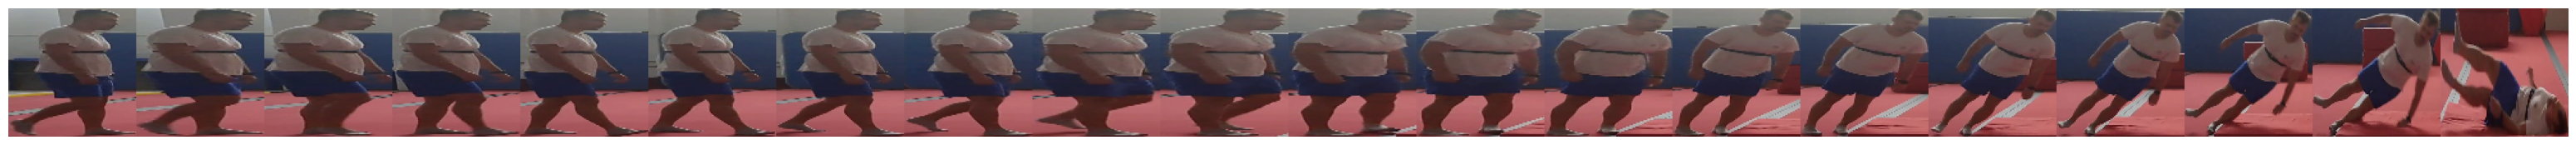

In [11]:
plt.figure(figsize=(40, 2))  # width=12in, height=6in
plt.imshow(cv2.cvtColor(array, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [ ]:
refPaths = {'fall' : '../Kaggle/Fall/Raw_Image', 'no_fall' : '../Kaggle/No_Fall/Raw_Image'}
key = 'no_fall'
start_from = 0
crops_number = 15
crops_size = (100,100)

for en, path in enumerate(videos[key]):
    print(en, path)

    if en < start_from:
        continue

    crops = get_person_crops(path, model_path='yolo11l.pt')

    print(f'crops length {len(crops)}')
    if not crops:
        continue
    
    crops_resized = resize_images(crops, crops_size)
    crops_resized_sample, _ = sub_sample(crops_resized, crops_number)
    array = np.concatenate(crops_resized_sample, axis=1)

    prefix = path.stem
    images = crops_resized_sample + [array]
    refPath = refPaths[key]
    save_images(images, refPath=refPath, prefix=prefix)

0 ../Kaggle/No_Fall/Raw_Video/B_D_0001.mp4
crops length 150
Saved 16 images to ../Kaggle/No_Fall/Raw_Image
1 ../Kaggle/No_Fall/Raw_Video/B_D_0002.mp4
crops length 60
Saved 16 images to ../Kaggle/No_Fall/Raw_Image
2 ../Kaggle/No_Fall/Raw_Video/B_D_0003.mp4
crops length 155
Saved 16 images to ../Kaggle/No_Fall/Raw_Image
3 ../Kaggle/No_Fall/Raw_Video/B_D_0004.mp4
crops length 82
Saved 16 images to ../Kaggle/No_Fall/Raw_Image
4 ../Kaggle/No_Fall/Raw_Video/B_D_0005.mp4
crops length 90
Saved 16 images to ../Kaggle/No_Fall/Raw_Image
5 ../Kaggle/No_Fall/Raw_Video/B_D_0006_resized.mp4
crops length 180
Saved 16 images to ../Kaggle/No_Fall/Raw_Image
6 ../Kaggle/No_Fall/Raw_Video/B_D_0007_resized.mp4
crops length 60
Saved 16 images to ../Kaggle/No_Fall/Raw_Image
7 ../Kaggle/No_Fall/Raw_Video/B_D_0008_resized.mp4
